<a href="https://colab.research.google.com/github/t2wain/colab/blob/master/Learn_MNIST_data_set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import math

# Inspecting data

In [0]:
digits = datasets.load_digits()

In [0]:
print("data:", digits.data.shape, type(digits.data))
print("target:", digits.target.shape, type(digits.target))
print("target_names:", digits.target_names.shape, type(digits.target_names))
print("images:", digits.images.shape, type(digits.images))

data: (1797, 64) <class 'numpy.ndarray'>
target: (1797,) <class 'numpy.ndarray'>
target_names: (10,) <class 'numpy.ndarray'>
images: (1797, 8, 8) <class 'numpy.ndarray'>


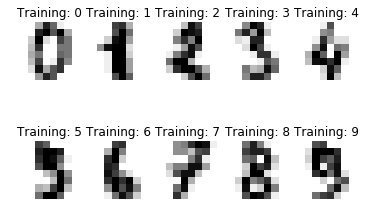

In [0]:
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:10]):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

# Example 1

## Utility methods

In [0]:
def data_gen(X, Y=None, batch_size=1, epochs=1):
  X_size, _ = X.shape

  for step in range(epochs):
    for step in range(X_size // batch_size):
      offset = (step * batch_size) % X_size
      batch_x = X[offset:(offset + batch_size), :]
      batch_y = None if Y is None else Y[offset:(offset + batch_size)]
      yield (batch_x, batch_y)
    if X_size % batch_size > 0:
      step += 1
      offset = (step * batch_size) % X_size
      batch_x = X[offset:, :]
      batch_y = None if Y is None else Y[offset:]
      yield (batch_x, batch_y)

In [0]:
def build_dnn(num_features, num_labels, hiddens=[]):
  
  def loss(Y, y_prob):
    xentropy = -tf.reduce_sum(Y * tf.log(y_prob), reduction_indices=1)
    loss = tf.reduce_mean(xentropy, name='cost')
    return loss


  def loss_logit(Y, logit):
    xentropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit, labels=Y)
    loss = tf.reduce_mean(tf.reduce_sum(xentropy), name='cost')
    #loss = tf.reduce_sum(xentropy, name='cost')
    return loss


  num_sample = None
  with tf.name_scope('placeholders'):
    Xin = tf.placeholder(tf.float32, shape=[num_sample, num_features], name='Xin')
    Yin = tf.placeholder(tf.float32, shape=[num_sample, num_labels], name='Yin')
    rate = tf.placeholder(tf.float32, name='dropout_rate')
  
  X = Xin; W = None; layers = []; y_out = None
  # create nodes for hidden layers
  num_input = num_features
  num_hidden_layers = len(hiddens)

  for layer_num, num_node_output in enumerate(hiddens):
    layer_name = "hidden_layer_%d" % (layer_num+1)
    with tf.name_scope(layer_name):
      with tf.variable_scope(layer_name):
        W = tf.get_variable('W', 
          initializer=tf.truncated_normal([num_input, num_node_output], stddev=0.1))
        b = tf.get_variable('b', 
          initializer=tf.Variable(tf.constant(0.1,shape=[num_node_output])))
      fx = tf.add(tf.matmul(X, W), b) # linear regression
      y_out = tf.nn.relu6(fx) # activation funtion to introduce non-linearity
      # apply dropout to hidden layer to introduce regularization of W
      layer_drop = tf.nn.dropout(y_out, rate=rate, name='y_out')
      y_out = layer_drop
      # keeping track of each layer
      layers.append({"W": W, "b": b, "out": y_out, "W_val": None, "b_val": None})
      X = y_out # y become Xin to next layer
      num_input = num_node_output
  
  # create output layer
  num_input = num_features if W is None else num_input
  num_node_output = num_labels
  with tf.name_scope('output'):
    with tf.variable_scope('output'):
      W = tf.get_variable('W', 
        initializer=tf.truncated_normal([num_input, num_node_output], stddev=0.1))
      b = tf.get_variable('b', 
        initializer=tf.constant(0.1,shape=[num_node_output]))
    y_logit = tf.add(tf.matmul(X, W), b) # logistic regression, ln-odd
    # convert to probability, exp-logit, and normalize to interval between 0 and 1
    y_prob = tf.nn.softmax(y_logit, name='y_prob')
    layers.append({"W": W, "b": b, "out": y_prob, "W_val": None, "b_val": None})
    y_pred = tf.argmax(y_prob, 1, name='y_pred') # index of max probablity
    y_label = tf.argmax(Yin, 1, name='y_label') # index of one-hot label

  with tf.name_scope('optimize'):
    cost = loss_logit(Yin, y_logit)
    #cost = loss(Yin, y_prob)
    op = tf.train.AdamOptimizer()
    # minimize cost/loss
    train_op = op.minimize(cost)
  
  with tf.name_scope('metrics'):
    correct_prediction = tf.equal(y_pred, y_label)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"), name='accuracy')
  
  return {"x": Xin, "y": Yin, "dropout_rate": rate, "layers": layers, 
          "cost": cost, "accuracy": accuracy, "y_prob": y_prob, "y_pred": y_pred,
          "op": op, "train_op": train_op}

In [0]:
def build_classifier_estimator(num_features, num_labels, hiddens=[], msg_per_steps=0):
  is_saved = False
  
  g1 = tf.Graph()
  with g1.as_default() as graph:
    dnn = build_dnn(num_features, num_labels, hiddens)

  # placeholders, input to the training
  X = dnn["x"]
  Y = dnn["y"]
  rate = dnn["dropout_rate"]

  # optimizer
  op = dnn["op"]
  train_op = dnn["train_op"]

  # metrics
  cost = dnn["cost"]
  accuracy = dnn["accuracy"]
  y_pred = dnn["y_pred"]
  y_prob = dnn["y_prob"]
  

  def train(xsample, ysample,  batch_size=1, training_epochs=1, 
            learning_rate=0.001, dropout_rate=0, max_loss=0.01, limit_count=4):
    op.learning_rate = learning_rate
    loss_count = 0
    with tf.Session(graph=g1) as sess:
      _restoreVars(sess)
      step_iterator = enumerate(data_gen(xsample, ysample,  batch_size, training_epochs))
      for step, (batch_xs, batch_labels) in step_iterator:
        feed_dict = {X: batch_xs, Y: batch_labels, rate: dropout_rate}
        sess.run(train_op, feed_dict=feed_dict)

        # print training progress
        if msg_per_steps > 0 and step % msg_per_steps == 0:
          feed_dict = {X: batch_xs, Y: batch_labels, rate: 0}
          cost_val, accuracy_val = sess.run([cost, accuracy], feed_dict=feed_dict)
          print(
              "Iteration", str(step), 
              "\t| Loss =", str(cost_val), 
              "\t| Accuracy =", str(accuracy_val))
          
        # early training stop
        if math.isnan(cost_val) or loss_count > limit_count:
          break;
        elif cost_val < max_loss:
          loss_count += 1
          
      _saveVars(sess)

      
  def _restoreVars(sess):
    sess.run(tf.global_variables_initializer())
    if is_saved:
      for layer in dnn["layers"]:
        sess.run(layer["W"].assign(layer["W_val"]))
        sess.run(layer["b"].assign(layer["b_val"]))

    
  def _saveVars(sess):
    nonlocal is_saved
    is_saved = True
    for layer in dnn["layers"]:
      layer["W_val"] = sess.run(layer["W"])
      layer["b_val"] = sess.run(layer["b"])

      
  def evaluate(xsample, ysample, batch_size=1):
    if not is_saved:
      return "Error: Training has not been done."

    with tf.Session(graph=g1) as sess:
      _restoreVars(sess)
      cost_total = accuracy_total = step = 0
      for step, (batch_xs, batch_ys) in enumerate(data_gen(xsample, ysample,  batch_size)):
        feed_dict = {X: batch_xs, Y: batch_ys, rate: 0}
        cost_val, accuracy_val = sess.run([cost, accuracy], feed_dict=feed_dict)
        cost_total += cost_val
        accuracy_total += accuracy_val
      return (cost_val/(step+1), accuracy_total/(step+1))

    
  def predict(xdata, labels, batch_size=1):
    if not is_saved:
      return "Error: Training has not been done."
      
    with tf.Session(graph=g1) as sess:
      _restoreVars(sess)
      pred = []; prob = []
      for (batch_xs, _) in data_gen(xdata, batch_size=batch_size):
        feed_dict={X: batch_xs, rate: 0}
        ypred = sess.run(y_pred, feed_dict=feed_dict)
        yprob = sess.run(y_prob, feed_dict=feed_dict)
        pred.extend(ypred)
        prob.extend(yprob.round(3))
        
      df = pd.DataFrame(prob, columns=labels)
      plabel = labels[pred]
      df["ypred"] = plabel
      return df

    
  return (train, evaluate, predict)

In [0]:
def one_hot(labels, ydata):
  y_target = np.expand_dims(ydata, axis=1)
  enc = OneHotEncoder(categories=[labels])
  enc.fit(y_target)
  return (labels, enc.transform(y_target).toarray())

## Example

In [0]:
def get_tensors_ex():
  g1 = tf.Graph()
  with g1.as_default() as graph:
    dnn = build_dnn(3, 4, [2,2])
    t = {"x": graph.get_tensor_by_name('placeholders/Xin:0'), 
        "y": graph.get_tensor_by_name('placeholders/Yin:0'), 
        "dropout_rate": graph.get_tensor_by_name('placeholders/dropout_rate:0'), 
        "cost": graph.get_tensor_by_name('optimize/cost:0'), 
        "accuracy": graph.get_tensor_by_name('metrics/accuracy:0'), 
        "out": graph.get_tensor_by_name('output/y_pred:0')}
  return (dnn, t)


get_tensors_ex()

In [0]:
def ex(nsample=None):
  ds = datasets.load_digits()
  
  batch_size = 128
  learning_rate = 0.0001
  hidden_layers = [256,256]
 
  if nsample==None:
    xsample = ds.data
    ysample = ds.target
  else:
    sel_idx = random.sample(range(1, ds.data.shape[0]), nsample)
    xsample = ds.data[sel_idx]
    ysample = ds.target[sel_idx]
    
  # normalization
  xsample = np.apply_along_axis((lambda x: (x - x.mean()) / x.std()),
    axis=1, arr=xsample.astype('float32'))

  # one-hot encoding the target
  y_labels, y_dummies = one_hot(ds.target_names, ysample)
  
  # split dataset into train and test
  x_train, x_test, y_train, y_test = train_test_split(
    xsample, y_dummies, test_size=0.3)
  
  # normalize training data
  # x_train = np.apply_along_axis((lambda x: (x - x.mean()) / x.std()),
  #   axis=1, arr=x_train.astype('float32'))

  train_size, num_features = x_train.shape
  num_labels = ds.target_names.shape[0]
  
  # build classifier
  (_train, _evaluate, _predict) = build_classifier_estimator(
      num_features, num_labels, hidden_layers, 200)


  def train(epochs=300):
    _train(x_train, y_train, batch_size, epochs, learning_rate, 0.45, 0.1, 4)


  def evaluate():
    (cost_val, accuracy_val) = _evaluate(x_train, y_train, batch_size)
    print("Train metric:")
    print({"accuracy": accuracy_val, "loss": cost_val})
    
    (cost_val, accuracy_val) = _evaluate(x_test, y_test, batch_size)
    print("Test metric:")
    print({"accuracy": accuracy_val, "loss": cost_val})


  def predict():
    df = _predict(x_test, ds.target_names, batch_size)
    ydata = ds.target_names[np.argmax(y_test, axis=1)]
    df["ydata"] = ydata
    return df


  return (train, evaluate, predict)

In [8]:
(ex_train, ex_eval, ex_predict) = ex()
ex_train(1000)

Iteration 0 	| Loss = 299.53745 	| Accuracy = 0.109375
Iteration 200 	| Loss = 8.64798 	| Accuracy = 0.984375
Iteration 400 	| Loss = 2.4611244 	| Accuracy = 0.9921875
Iteration 600 	| Loss = 1.0726773 	| Accuracy = 1.0
Iteration 800 	| Loss = 0.23384434 	| Accuracy = 1.0
Iteration 1000 	| Loss = 0.15774536 	| Accuracy = 1.0
Iteration 1200 	| Loss = 0.07114814 	| Accuracy = 1.0


In [9]:
ex_eval()

Train metric:
{'accuracy': 1.0, 'loss': 0.0009413301944732666}
Test metric:
{'accuracy': 0.9828125, 'loss': 0.12605146169662476}


In [0]:
df = ex_predict()

In [11]:
print("Correct prediction:")
df.loc[df["ypred"] == df["ydata"]]


Correct prediction:


,0,1,2,3,4,5,6,7,8,9,ypred,ydata
0,0.000,0.000,1.0,0.000,0.000,0.000,0.0,0.0,0.000,0.000,2,2
1,0.000,0.000,0.0,0.000,0.000,0.000,0.0,1.0,0.000,0.000,7,7
2,0.002,0.948,0.0,0.002,0.001,0.018,0.0,0.0,0.004,0.026,1,1
4,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.0,1.000,0.000,8,8
5,0.000,0.000,0.0,0.000,0.000,0.000,0.0,1.0,0.000,0.000,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...
535,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.000,1.000,9,9
536,0.000,0.000,0.0,1.000,0.000,0.000,0.0,0.0,0.000,0.000,3,3
537,0.000,0.000,0.0,1.000,0.000,0.000,0.0,0.0,0.000,0.000,3,3
538,0.000,0.999,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.000,1,1


In [12]:
print("Wrong prediction:")
df.loc[df["ypred"] != df["ydata"]]

Wrong prediction:


,0,1,2,3,4,5,6,7,8,9,ypred,ydata
3,0.000,0.000,0.000,0.004,0.000,0.000,0.000,0.000,0.752,0.243,8,9
55,0.020,0.601,0.000,0.000,0.024,0.267,0.005,0.004,0.039,0.040,1,8
86,0.000,0.006,0.000,0.139,0.000,0.847,0.001,0.000,0.000,0.005,5,3
97,0.010,0.022,0.000,0.000,0.093,0.630,0.036,0.000,0.104,0.105,5,1
112,0.465,0.000,0.000,0.000,0.494,0.000,0.039,0.000,0.001,0.000,4,0
147,0.010,0.000,0.000,0.001,0.001,0.057,0.000,0.025,0.001,0.905,9,7
217,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,9,5
252,0.000,0.000,0.000,0.000,0.000,0.320,0.680,0.000,0.000,0.000,6,5
309,0.000,0.929,0.000,0.000,0.002,0.000,0.065,0.000,0.004,0.000,1,8
413,0.000,0.000,0.802,0.008,0.000,0.000,0.000,0.000,0.190,0.000,2,3
